<div class="usecase-section-header">Greening Laneways to reduce overland water flow events</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>

<div class="usecase-duration"><b>Duration:</b>60 mins</div>
<div class="usecase-level"><b>Level: </b>beginner</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>

<div class="usecase-section-header">Scenario</div>

1. As a city planner, I want to identify the laneways that could most benefit from planting to reduce overland water runoff as part of the Greening Your Laneway program.

2. As a building manager or residence owner, I want to visualise the potential of laneway greening in reducing water damage to my property from overflow events.

<div class="usecase-section-header">Learning Objectives</div>

At the end of this use case you will be able to:
* Work with spatial databases using Geopandas
* Visualise spatial data on an interactive map

<div class="usecase-section-header">Greening Laneways to Reduce Runoff</div>

##### **What is the Green Your Laneway Program?**

The green laneways program was established in 2017 with aa pilot project of four Laneways: Katherine Place, Meyers Place, Guildford Lane and Coromandel Place. These laneways were greened using a mixture of potted plants on windowsills and nature strips as well as creeper vines. The benefits of greening laneways includes:

- oxygen production for fresh air to breathe
- storage of carbon dioxide, helping reduce green house gases
- trees absorb water, helping reduce flooding events
- evapotranspiration from leaves produces a cooling effect, reducing heat waves
- provide habitats for wildlife
- trees reduce cortisol in our brains, improving mental health and wellbeing

More information:
https://www.treesforcities.org/stories/trees-in-our-cities-10-reasons-we-need-to-plant-more


##### **How do plants reduce surface water overflow?**

Plants and soil will absorb some of the excess water during rain events. One problem that occurs within Melboune city is the runoff of water over roads. Due to non-permeable surfaces, water runs across the top of the land prior to enterinng a stormwater drain, causing "rivers" of water on roads and laneways in the CBD.  For this reason, consideration of the locations where water flows over land should be investigated in regards to choosing laneway locations for future greening projects.

<div class="usecase-section-header">Relevant datasets</div>

[Laneways with Greening Potential](https://data.melbourne.vic.gov.au/explore/dataset/laneways-with-greening-potential/export/)
- The City of Melbourne collected data analysing the best potential type of plantings in each of the city laneways; farm plantings, park species, vertically growing species and forest type species. Each type of planting was given a categorical value of potential for types of planting: Highest, Good, Some or Lowest.

[Water flow routes over land (Urban Forest)](https://data.melbourne.vic.gov.au/explore/dataset/water-flow-routes-over-land-urban-forest/export/)
- Data was collected in 2008 using an ESRI Spatial Analyst stream order tool. 

<div class="usecase-section-header">Exploratory data analysis steps</div>

1. Import modules
2. Access and read in data sets using API v2.1 as Geopandas files
3. Map overlap locations of water runoff and laneways



In [20]:
# Import modules
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
from shapely.geometry import Polygon
import folium


In [3]:
# Function to get data from website using API
def get_data_single(base, SPECIFIC_PATH, apikey, offset=0):    
    # Set the filters, limit retrieves 20 rows at a time, offset says where to start data collection
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    # Make the url from base, data url and filters variables stored ouside loop
    url = f'{base}{SPECIFIC_PATH}/{filters}&apikey={apikey}'
    # print(url) - can be used locally to check if code is working if 404 error given
    # Use the requests function to get the data
    result = requests.get(url)
    # Check that the request works, error code 200 = successful
    if result.status_code == 200:
        # Save results as a json file
        result_json = result.json()
        # Store a variable of max_results with total of dataset
        max_results = result_json['total_count']
        # Save the results key data to a list variable
        records = result_json['results']
    else:
        # If data is not collected correctly return the error
        print("ERROR GETTING DATA: ", result.status_code)
        max_results = 0
        records = []
    # At end of function, return the json results in records, max_results count and offset
    return [records, max_results, offset]


def fetch_all_data(SPECIFIC_PATH):
    # Collect data from API
    # Set offset increment
    # (needs to match offset in get data function)
    OFFSET_INCREMENT = 100
    # Base url (this should be the same for all datasets)
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    # Set your API key
    # Set path to your API key
    # (needs to be a destination on your local device where API is kept)
    path = 'C:/Users/alito/Documents/SIT764/MOP-Code/env.txt'
    apikey_local = open(path, 'r')
    apikey = apikey_local.read()   
    # Call the get data function, passing in variables above, save to result
    result = get_data_single(base_url, SPECIFIC_PATH, apikey)
    # Save the records data returned in the get_data function to records list variable
    records = result[0]
    # Save the dataset size data returned in the get_data function to max_results variable
    max_results = result[1] 
    # Increase the offset returned in the get_data function (result[2]) by the offset increment
    offset = result[2] + OFFSET_INCREMENT
    # Check the length of the data returned and compare it against the max_results variable
    # If the length o fthe data is less than the max_results, run the while loop
    while len(records) != max_results:
        # Call the get data function again, passing in url, specific path and new offset value
        data = get_data_single(base_url, SPECIFIC_PATH, apikey, offset)
        # Add the data collected to the existing records list
        records += data[0]
        # Increase the offset by the offset increment
        offset += OFFSET_INCREMENT
    # Convert the records list of dictionaries into a pandas dataframe 
    df = pd.DataFrame(records)
    # Print the dataframe
    return df

In [4]:
# Read in Laneways with Greening Potential Dataset
# Set specific url 
SPECIFIC_PATH = 'laneways-with-greening-potential'
# Collect data
lane_df = fetch_all_data(SPECIFIC_PATH)
# Parse wkt format dataframe through shapely
# Convert to pandas geodata frame
# Extract the geo_point_2d column and put into a new dataframe as two columns, lat and lon
parsed = pd.DataFrame.from_records(lane_df['geo_point_2d'])
# Add extracted columns lat and lon to lane dataframe
lane_df[['lon','lat']]= parsed[['lon','lat']]
# Convert lane dataframe to geodataframe, joiing lon and lat columsn to make a geometry column
lane_gdf = gpd.GeoDataFrame(
    lane_df, geometry=gpd.points_from_xy(lane_df.lon, lane_df.lat), crs="EPSG:4326")
lane_gdf.head(2)

,geo_point_2d,geo_shape,segid_1,mapbase_mc,insol_scor,verticalsu,segid,driveways,parklane,objectid,...,vert_rank,fores_rank,forest,park_rank,binsperct,mapbase_1,wsud,lon,lat,geometry
0,"{'lon': 144.9623447558369, 'lat': -37.81980050...","{'type': 'Feature', 'geometry': {'coordinates'...",10714,10714.0,6.492595,0.0,10714,1,53.830526,1,...,Lowest potential,Lowest potential,0.000000,Highest potential,0.0,Banana Alley,Probably Unsuitable,144.962345,-37.819801,POINT (144.96234 -37.81980)
1,"{'lon': 144.97170834375964, 'lat': -37.8109763...","{'type': 'Feature', 'geometry': {'coordinates'...",20229,20229.0,2.215613,0.0,20229,2,0.000000,5,...,Lowest potential,Good potential,49.153357,Lowest potential,60.0,Harwood Place,Consider,144.971708,-37.810976,POINT (144.97171 -37.81098)


In [26]:
# Read in Water flow routes over land (Urban Forest) Dataset
# Set specific url 
SPECIFIC_PATH = 'water-flow-routes-over-land-urban-forest'
# Collect data
water_df = fetch_all_data(SPECIFIC_PATH)
# Convert to pandas geodata frame
  
water_df.head(2)


,geo_point_2d,geo_shape,grid_code,source,to_node,arcid,from_node
0,"{'lon': 144.93012309946076, 'lat': -37.8091117...","{'type': 'Feature', 'geometry': {'coordinates'...",3,2008 DEM to stream order using ESRI Spatial An...,3112,3502,3111
1,"{'lon': 144.9260809159682, 'lat': -37.80905866...","{'type': 'Feature', 'geometry': {'coordinates'...",1,2008 DEM to stream order using ESRI Spatial An...,3117,3510,3116


In [39]:
# check type of object in geo_shape column
print(water_df.geo_shape[1])
df = gpd.GeoDataFrame.from_features(water_df.geo_shape)
print(df)


{'type': 'Feature', 'geometry': {'coordinates': [[[144.92607523946074, -37.80905856409324], [144.92608659247566, -37.80905876405037]]], 'type': 'MultiLineString'}, 'properties': {}}
                                               geometry
0     MULTILINESTRING ((144.93012 -37.80911, 144.930...
1     MULTILINESTRING ((144.92608 -37.80906, 144.926...
2     MULTILINESTRING ((144.93013 -37.80912, 144.930...
3     MULTILINESTRING ((144.93254 -37.80888, 144.932...
4     MULTILINESTRING ((144.92606 -37.80906, 144.926...
...                                                 ...
7696  MULTILINESTRING ((144.98041 -37.84872, 144.980...
7697  MULTILINESTRING ((144.91191 -37.84773, 144.911...
7698  MULTILINESTRING ((144.91236 -37.84837, 144.912...
7699  MULTILINESTRING ((144.91236 -37.84837, 144.912...
7700  MULTILINESTRING ((144.91240 -37.84907, 144.912...

[7701 rows x 1 columns]


<Axes: >

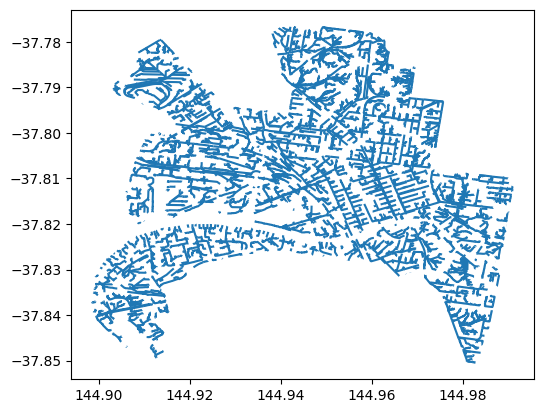

In [40]:
df.plot()

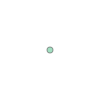

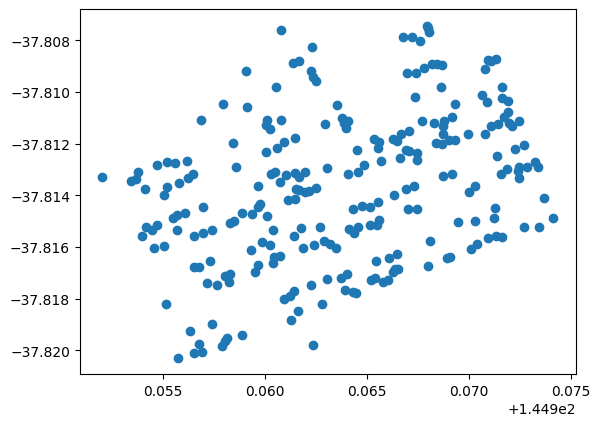

In [6]:

# check type of data in dataframe
type(lane_gdf)
# call plot function to plot lane_gdf dataset
lane_gdf.plot()
lane_gdf.geometry[4]

<Axes: >

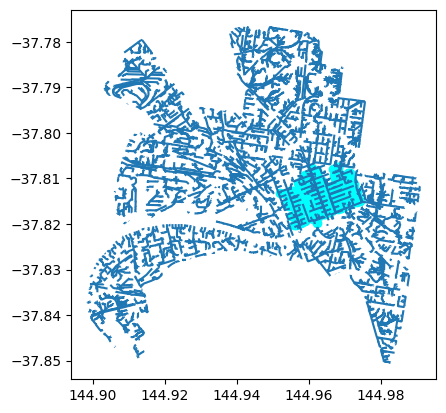

In [41]:
# plot two maps on same axis. This plots laneways on top of water
# need to select locations to CBD
ax = df.plot()
lane_gdf.plot(ax=ax, color='cyan')


In [9]:
# Set a map called m, using folium, set position(lat,long) and zoom to open at
map = folium.Map([-37.8140,144.9633], zoom_start=15)
# Convert lane_gdf to json and add to map, using folium method
folium.GeoJson(lane_gdf.to_json()).add_to(map)
# call m to open the map
map

In [14]:
# Plot the names of the laneways onto the map
import plotly.express as px
import plotly.io as pio
pio.renderers
pio.renderers.default = "notebook_connected"
from plotly.offline import plot
fig = px.scatter_mapbox(lane_gdf,
                        lat = "lat",
                        lon = "lon",
                        hover_name = "mapbase_1",
                        hover_data = ["mapbase_1"],
                        zoom = 13,
                        center = dict(lon=144.9633, lat=-37.8140),
                        height = 400,
                        width = 600,)
fig.update_layout(mapbox_style = "open-street-map")
fig.update_layout(title_text = "Names of lanes")
fig.show()